<a href="https://colab.research.google.com/github/google/business_intelligence_group/blob/main/CausalImpact_with_Experiment_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CausalImpact with Experiment Design**

This Colab file contain..

*Experiment Design*
* Load Data
* Experiment Design
* Simulation

*CausalImpact Analysis*
* Load Data
* CausalImpact Analysis

See README.md for details

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/business_intelligence_group/blob/main/solutions/causal-impact/CausalImpact_with_Experiment_Design.ipynb)

---

Copyright 2022 Google LLC

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Initial Settings

Pass through the necessary libraries and certifications for the analysis.

There will be a pop-up on the way to access the spreadsheet, so please approve it.

In [ ]:
!pip install tfcausalimpact

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.6 MB 43.9 MB/s 
     |████████████████████████████████| 588.3 MB 23 kB/s 
     |████████████████████████████████| 6.0 MB 49.3 MB/s 
     |████████████████████████████████| 1.7 MB 77.6 MB/s 
     |████████████████████████████████| 439 kB 66.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

In [ ]:
from google.colab import auth
from google.colab import files
from google.colab import widgets
from google.auth import default

from causalimpact import CausalImpact
from IPython.display import display
from IPython.display import Markdown
from oauth2client.client import GoogleCredentials
from scipy.spatial.distance import euclidean
from sklearn.metrics import mean_absolute_percentage_error

import altair as alt
import datetime
import fastdtw
import gspread
import io
import ipywidgets
import itertools
import numpy as np
import pandas as pd
import random

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
#@markdown class PreProcess
class PreProcess(object):
  """PreProcess read, format, and check the data needed
  before Experiment Design.

  Attributes:
    load_data_from_sheet: Read data from spreadsheet
    load_data_from_csv: Read data from CSV
    shape_wide: Pivots the data in the specified column
    trend_check: Visualize series data
    __get_converted_multi_columns: Column Name Concatenation
  """

  def __init__(self):
    pass

  def load_data_from_sheet(self, spreadsheet_url, sheet_name):
    """load_data_from_sheet read data from spreadsheet.
    Confirmation of data types and presentation of basic statistics

    Args:
      spreadsheet_url: Spreadsheet url with data.
      sheet_name: Sheet name with data.

    Returns:
      df_sheet: Data from spreadsheet
    """
    self.workbook = gc.open_by_url(spreadsheet_url)
    self.worksheet = self.workbook.worksheet(sheet_name)
    self.df_sheet = pd.DataFrame(self.worksheet.get_all_values())
    self.df_sheet.columns = list(self.df_sheet.loc[0, :])
    self.df_sheet.drop(0, inplace=True)
    self.df_sheet.reset_index(drop=True, inplace=True)
    self.df_sheet = self.df_sheet.apply(pd.to_numeric, errors='ignore')
    self.df_sheet.replace(',', '', regex=True, inplace=True)
    self.tb = widgets.TabBar(['head', 'dtypes', 'describe'])

    with self.tb.output_to('head'):
      display(self.df_sheet.head(10))
    with self.tb.output_to('dtypes'):
      display(pd.DataFrame(self.df_sheet.dtypes, columns=['dtypes']))
    with self.tb.output_to('describe'):
      display(self.df_sheet.describe(include='all'))
    with self.tb.output_to('head'):
      pass

  def load_data_from_csv(self, csv_name):
    """load_data_from_csv read data from csv.
    Confirmation of data types and presentation of basic statistics

    Args:
      csv_name: csv file name.

    Returns:
      df_sheet: Data from csv
    """
    uploaded = files.upload()
    self.df_sheet = pd.read_csv(io.BytesIO(uploaded[csv_name]))
    self.df_sheet = self.df_sheet.apply(pd.to_numeric, errors='ignore')
    self.df_sheet.replace(',', '', regex=True, inplace=True)
    self.tb = widgets.TabBar(['head', 'dtypes', 'describe'])

    with self.tb.output_to('head'):
      display(self.df_sheet.head(10))
    with self.tb.output_to('dtypes'):
      display(pd.DataFrame(self.df_sheet.dtypes, columns=['dtypes']))
    with self.tb.output_to('describe'):
      display(self.df_sheet.describe(include='all'))
    with self.tb.output_to('head'):
      pass

  def shape_wide(self, dataframe, date_column, group_column, kpi_column):
    """shape_wide pivots the data in the specified column.

    Converts long data to wide data suitable for experiment design using
    fastDTW.

    Args:
      date_column: Date column name.
      group_column: Columns name that are pivot keys for regions, etc.
      kpi_column: KPI column name.

    Returns:
      df_sheet: Widely formatted data with 0s in the missing values
    """
    self.group_cols = []
    if group_column.count(',') == 0:
      self.group_cols.append(group_column)
    else:
      self.group_cols = group_column.replace(' ', '').split(',')

    self.df_sheet = dataframe[[date_column, kpi_column, *self.group_cols
                             ]].groupby([date_column,
                                         *self.group_cols]).sum().reset_index()
    self.df_sheet = pd.pivot_table(
        self.df_sheet, index=date_column, columns=self.group_cols)
    self.df_sheet.columns = self.df_sheet.columns.droplevel(0)
    if len(self.df_sheet.columns.names) == 1:
      pass
    else:
      self.df_sheet.columns = self.__get_converted_multi_columns(self.df_wide)

    self.df_sheet.index = pd.to_datetime(self.df_sheet.index)
    self.df_sheet.index.rename('date', inplace=True)
    self.df_sheet.fillna(0, inplace=True)
    display(self.df_sheet)

  def __get_converted_multi_columns(self, df):
    return [col[0] + '_' + col[1] for col in df.columns.values]

  def trend_check(self, dataframe_wide):
    """trend_check visualize daily trend, 7-day moving average

    Args:
      dataframe_wide: Wide data to check the trend

    Returns:
      Daily trend and 7-day moving average
      Scaled daily trend by column
      Basic statistics by column
    """
    self.df_long = pd.melt(
        dataframe_wide.reset_index(),
        id_vars='date').groupby('date').sum().reset_index()
    self.line = alt.Chart(self.df_long).mark_line().encode(
        x=alt.X('date', axis=alt.Axis(title='')),
        y=alt.Y('value:Q', axis=alt.Axis(title='kpi')),
        color=alt.value('#4285F4'))
    self.moving_average = alt.Chart(self.df_long).transform_window(
        rolling_mean='mean(value)',
        frame=[-7, 0],
    ).mark_line().encode(
        x=alt.X('date'), y=alt.Y('rolling_mean:Q'), color=alt.value('#DB4437'))

    self.df_scaled = dataframe_wide.copy()
    for column in self.df_scaled:
      self.df_scaled[column] = (
          self.df_scaled[column] - self.df_scaled[column].min()) / (
              self.df_scaled[column].max() - self.df_scaled[column].min())

    self.df_scaled_cols = list(self.df_scaled.columns)
    self.step = 50
    self.each = alt.Chart(self.df_scaled.reset_index()).transform_fold(
        self.df_scaled_cols, as_=['geo', 'kpi']).mark_line().encode(
            alt.X('date:T', title=None, axis=alt.Axis(grid=False)),
            alt.Y('kpi:Q', stack=None, axis=None), alt.Color('geo:N'),
            alt.Row(
                'geo:N',
                title=None,
                header=alt.Header(labelAngle=0, labelAlign='left'))).properties(
                    bounds='flush', height=int(
                        self.step)).configure_facet(spacing=0).configure_view(
                            stroke=None).configure_title(anchor='end')

    self.data_tb = widgets.TabBar(['all', 'each', 'describe'])
    with self.data_tb.output_to('all'):
      display((self.line + self.moving_average).properties(
          width=800, height=400, title={
              'text': ['日次 推移(青) & 7日間移動平均(赤)'],
          }))
    with self.data_tb.output_to('each'):
      display((self.each).properties(width=800))
    with self.data_tb.output_to('describe'):
      display(dataframe_wide.describe(include='all'))
    with self.data_tb.output_to('all'):
      pass

In [ ]:
#@markdown class ExperimentDesign
class ExperimentDesign(object):
  """ExperimentDesign runs xxx

  Attributes:
    drop_cols:
    equal_division:
    similar_divisions:
    _run_dtw:
    _visualize_trend_diff:
    select_dataframe:
    causalimpact_simulation:
  """

  def __init__(self):
    pass

  def drop_cols(self, dataframe_wide, answer, un_needed_cols):
    if answer == 'Yes':
      self.un_needed_cols_list = un_needed_cols.split(',')
      self.df_wide_tgt = dataframe_wide.drop(self.un_needed_cols_list, axis=1)
    else:
      self.df_wide_tgt = dataframe_wide.copy()
    display(
      Markdown(f"""### Column List: {len(self.df_wide_tgt.columns)}
    """))
    it = iter(list(self.df_wide_tgt.columns))
    while True:
        try:
            print(next(it), ' | ' + next(it), ' | ' + next(it), ' | ' + next(it), ' | ' + next(it))
        except StopIteration:
            break

  def equal_division(self, dataframe_wide, num_of_iteration, num_of_split,
                     start_date, end_date):
    """equal_division xxx

    Xxx

    Args:
      xxx: xxx.

    Returns:
      xxx
    """
    self.df_dtw = pd.DataFrame(index=[], columns=[])
    self.dataframe = dataframe_wide.query('@start_date <= index <= @end_date')
    self.num_of_pick = len(self.dataframe.columns) // num_of_split

    for l in range(num_of_iteration):
      self.col_list = list(range(0, len(self.dataframe.columns)))
      self.choice_list = pd.DataFrame(index=[], columns=range(num_of_split))
      self.df_picked = pd.DataFrame(index=[], columns=[])
      self.df_candidate = pd.DataFrame()

      for s in range(num_of_split):
        self.tg = random.sample(self.col_list, self.num_of_pick)
        self.choice_list.loc[0, s] = self.tg
        self.col_list = [ele for ele in self.col_list if ele not in self.tg]

      self.choice_list.loc[0, s].extend(self.col_list)

      for i in range(len(self.choice_list.columns)):
        self.picked = pd.DataFrame(
            self.dataframe.iloc[:, self.choice_list.loc[0, i]].sum(axis=1),
            columns=[i])
        self.df_picked = pd.concat([self.df_picked, self.picked], axis=1)

      self.dtw_row = self._run_dtw(self.df_picked)

      for c in range(len(self.choice_list.columns)):
        self.dtw_row.append(str(self.choice_list.loc[0, c]))

      self.dtw_row = pd.DataFrame(self.dtw_row).T
      self.df_dtw = pd.concat([self.df_dtw, self.dtw_row], ignore_index=True)

    self.df_dtw = self.df_dtw.drop_duplicates().sort_values(0).reset_index(
        drop=True)
    self.df_dtw = self.df_dtw.head()

    self.df_dtw_columns = pd.DataFrame()
    for i in range(len(self.df_dtw)):
      for x in range(len(self.df_dtw.columns) - 1):
        self.df_dtw_columns.at[i, x] = str(
            list(self.dataframe.iloc[:, eval(self.df_dtw.iloc[i,
                                                              x + 1])].columns))

    self.df_dtw_values = pd.DataFrame()
    for i in range(len(self.df_dtw)):
      self.df_dtw_values.at[
          i,
          'date'] = self.dataframe.iloc[:, eval(self.df_dtw.iloc[
              i, x + 1])].sum(axis=1).reset_index()['date'].to_string(
                  index=False).replace(' ', '')
      for x in range(len(self.df_dtw.columns) - 1):
        self.df_dtw_values.at[
            i,
            x] = self.dataframe.iloc[:, eval(self.df_dtw.iloc[i, x + 1])].sum(
                axis=1).reset_index()[0].to_string(index=False).replace(
                    ' ', '')

    self._visualize_trend_diff(self.df_dtw_values, self.df_dtw_columns)

  def similar_divisions(self, dataframe_wide, target_geo, num_of_iteration,
                        num_of_pick, num_of_covariate, start_date, end_date):
    """similar_divisions xxx

    Xxx

    Args:
      xxx: xxx.

    Returns:
      xxx
    """
    self.df_dtw = pd.DataFrame()
    self.choice_list = pd.DataFrame()
    self.target_cols = []
    self.dataframe = dataframe_wide.query('@start_date <= index <= @end_date')

    for g in range(len(target_geo)):
      self.target_cols.append(self.dataframe.columns.values.tolist().index(
          target_geo[g]))
    ### Test
    # lot × pick <= other_geo length
    # num_pick = random.randrange(min_pick, len(l), 1)

    self.col_list = list(range(0, len(self.dataframe.columns)))
    for g in range(len(target_geo)):
      self.col_list.remove(self.dataframe.columns.values.tolist().index(
          target_geo[g]))

    for l in range(num_of_iteration):
      self.col_list_candidate = self.col_list.copy()
      self.choice_list = [self.target_cols]
      self.df_picked = pd.DataFrame()

      for s in range(num_of_covariate):
        self.tg = random.sample(self.col_list_candidate, num_of_pick)
        self.choice_list.append(self.tg)
        self.col_list_candidate = [
            ele for ele in self.col_list_candidate if ele not in self.tg
        ]

      for i in range(len(self.choice_list)):
        self.picked = pd.DataFrame(
            self.dataframe.iloc[:, self.choice_list[i]].sum(axis=1),
            columns=[i])
        self.df_picked = pd.concat([self.df_picked, self.picked], axis=1)

      self.dtw_row = self._run_dtw(self.df_picked)

      for c in range(len(self.choice_list)):
        self.dtw_row.append(str(self.choice_list[c]))

      self.dtw_row = pd.DataFrame(self.dtw_row).T
      self.df_dtw = pd.concat([self.df_dtw, self.dtw_row], ignore_index=True)

    self.df_dtw = self.df_dtw.drop_duplicates().sort_values(0).reset_index(
        drop=True)
    self.df_dtw = self.df_dtw.head()
    display(self.df_dtw)
    self.df_dtw_columns = pd.DataFrame()
    for i in range(len(self.df_dtw)):
      for x in range(len(self.df_dtw.columns) - 1):
        self.df_dtw_columns.at[i, x] = str(
            list(self.dataframe.iloc[:, eval(self.df_dtw.iloc[i,
                                                              x + 1])].columns))

    self.df_dtw_values = pd.DataFrame()
    for i in range(len(self.df_dtw)):
      self.df_dtw_values.at[
          i,
          'date'] = self.dataframe.iloc[:, eval(self.df_dtw.iloc[
              i, x + 1])].sum(axis=1).reset_index()['date'].to_string(
                  index=False).replace(' ', '')
      for x in range(len(self.df_dtw.columns) - 1):
        self.df_dtw_values.at[
            i,
            x] = self.dataframe.iloc[:, eval(self.df_dtw.iloc[i, x + 1])].sum(
                axis=1).reset_index()[0].to_string(index=False).replace(
                    ' ', '')

    self._visualize_trend_diff(self.df_dtw_values, self.df_dtw_columns)

  def _run_dtw(self, df_picked):
    """_run_dtw xxx

    Xxx

    Args:
      xxx: xxx.

    Returns:
      xxx
    """
    self.dist = 0
    self.df_dtw_row = []
    for column in df_picked:
      df_picked[column] = (df_picked[column] - df_picked[column].min()) / (
          df_picked[column].max() - df_picked[column].min())
    for v in itertools.combinations(list(df_picked.columns), 2):
      distance, path = fastdtw.fastdtw(
          df_picked.loc[:, v[0]], df_picked.loc[:, v[1]], dist=euclidean)
      self.dist = self.dist + distance
    self.df_dtw_row.append(self.dist)

    return self.df_dtw_row

  def _visualize_trend_diff(self, df_dtw_values, df_dtw_columns):
    """_visualize_trend_diff xxx

    Xxx

    Args:
      xxx: xxx.

    Returns:
      xxx
    """
    self.candidate_tb = widgets.TabBar(
        ['choice_' + str(sub+1) for sub in df_dtw_values.index.tolist()])

    for i in range(len(df_dtw_columns)):
      with self.candidate_tb.output_to(i):
        for col in range(len(df_dtw_columns.columns)):
          print('col' + str(col + 1) + df_dtw_columns.iloc[i, col])
          print('\n')

        self.df_candidate = pd.DataFrame(
            {'date': df_dtw_values.loc[i, 'date'].split('\n')})
        for col in range(len(df_dtw_values.columns) - 1):
          self.df_candidate = pd.concat([
              self.df_candidate,
              pd.Series(df_dtw_values.loc[i, col].split('\n'))
          ],
                                        ignore_index=True,
                                        axis=1)
        self.df_candidate = self.df_candidate.apply(
            pd.to_numeric, errors='ignore')
        self.df_candidate.set_index(0, inplace=True)
        self.df_candidate.index.rename('date', inplace=True)
        self.df_candidate = self.df_candidate.add_prefix('col')

        self.df_diff = pd.DataFrame(
            np.diff(self.df_candidate, axis=0),
            columns=self.df_candidate.columns.values)
        display(self.df_diff.corr())

        self.line = alt.Chart(self.df_candidate.reset_index()).transform_fold(
            [str(n) for n in list(self.df_candidate.columns)
            ],).mark_line().encode(
                alt.X('date:T'), alt.Y('value:Q'), color='key:N').properties(
                    width=600, height=250)

        self.scatter = alt.Chart(
            self.df_diff.reset_index()).mark_circle().encode(
                alt.X(alt.repeat('column'), type='quantitative'),
                alt.Y(alt.repeat('row'), type='quantitative'),
            ).properties(
                width=100, height=100).repeat(
                    row=self.df_diff.columns.values,
                    column=np.flipud(self.df_diff.columns.values))
        alt.vconcat(self.line, self.scatter).display()
    with self.candidate_tb.output_to(0):
      pass

  def select_dataframe(self, dataframe_wide, your_choice, test_col, df_dtw_columns):
    self.order = list(df_dtw_columns.columns)
    self.target_col = int(test_col.replace('col', ''))-1
    self.order.remove(self.target_col)
    self.order.insert(0, self.target_col)
    self.target_row = int(your_choice.replace('choice_', ''))-1
    self.row = list(df_dtw_columns.iloc[self.target_row])
    self.df = pd.DataFrame()

    self.colnames = ['test']
    for i in range(len(self.order) - 1):
      self.colnames.append('control_'+str(i+1))

    for i, x in zip(self.colnames, self.order):
      print('{0}: {1}'.format(i, self.row[x]))

      self.df = pd.concat(
          [
              self.df,
              dataframe_wide.loc[:,eval(self.row[x])].sum(axis=1)
          ], axis=1)

    self.df.set_axis(self.colnames, axis=1, inplace=True)
    return self.df

  def color_p_value(self, val):
    color = 'red' if val <= 0.05 else 'black'
    return 'color: %s' % color

  def simulate_params(self, dataframe, estimation_icpa):
    """ simulate_params simulates test period and budget requirements.

    Simulation data with different hypothetical time periods and effects are
    created from time series data and analyze impact using CausalImpact.
    Output the combination of period and budget that produces significant results.

    Args:
      dataframe: Time series data for CausalImpact
      estimation_icpa:

    Returns:
      sim_df: A data frame simulates the period and budget requirements
    """
    self.treat_duration = [7, 14, 28]
    self.treat_impact = [1.01, 1.03, 1.05, 1.10]
    self.simulation_combination = list(itertools.product(self.treat_duration, self.treat_impact))

    self.pre_start_date = pd.to_datetime(min(dataframe.index))
    self.post_end_date = pd.to_datetime(max(dataframe.index))
    self.adjusted_df = dataframe.copy()
    self.simulation = []
    self.simulation_df = pd.DataFrame(
        index=[],
        columns=[
            'days', 'impact', 'MAPE', 'abs_effect', 'mean', 'budget', 'p_value'
        ])

    for duration in self.treat_duration:
      self.pre_end_date = self.post_end_date + datetime.timedelta(days = - duration)
      self.post_start_date = self.pre_end_date + datetime.timedelta(days = 1)
      self.pre_period = [self.pre_start_date, self.pre_end_date]
      self.post_period = [self.post_start_date, self.post_end_date]

      for impact in self.treat_impact:
        self.adjusted_df.loc[dataframe.index >= self.post_start_date,
                  'test'] = dataframe.loc[dataframe.index >= self.post_start_date, 'test'] * impact
        self.adjusted_df.index = self.adjusted_df.index.map(str)
        self.ci = CausalImpact(self.adjusted_df, self.pre_period, self.post_period)
        self.simulation.append(self.ci)
        self.impact_dict = {
            'days': [duration],
            'impact': [impact],
            'MAPE': [mean_absolute_percentage_error(
                self.ci.data.test[self.ci.pre_period[0]:self.ci.pre_period[1]],
                self.ci.inferences.complete_preds_means[self.ci.pre_period[0]:self.ci.pre_period[1]])],
            'abs_effect': [self.ci.summary_data.loc['abs_effect','cumulative']],
            'mean': [self.ci.summary_data.loc['abs_effect','average']],
            'budget': [self.ci.summary_data.loc['abs_effect','cumulative'] * estimation_icpa],
            'p_value': [self.ci.p_value]
        }
        self.simulation_df = pd.concat([self.simulation_df, pd.DataFrame.from_dict(self.impact_dict)],
                          ignore_index=True)

    display(self.simulation_df.style.applymap(
        self.color_p_value, subset='p_value').format(
          '{:,.0f}', subset=['abs_effect', 'mean', 'budget']).format(
              '{:,.2f}', subset=['impact', 'p_value']).format(
              '{:,.2%}', subset=['MAPE']))
    self.simulation_tb = widgets.TabBar(self.simulation_combination)
    for i in range(len(self.simulation_combination)):
        with self.simulation_tb.output_to(i):
          print(self.simulation[i].summary())
          display(self.simulation[i].plot())
    with self.simulation_tb.output_to(0):
        pass

## Experiment Design

### Load Data

Please fill in the required fields to import data from a spreadsheet or CSV.

If the data is long data, it will be converted to wide data, so please fill in the required fields.

Finally, check the trend.

In [ ]:
#@markdown <font color='blue'><b>■ Select your Data Source</b></font>  (google_spreadsheet | csv)
case = PreProcess()
data_source = "google_spreadsheet" #@param ["google_spreadsheet", "csv"]
#@markdown <br><hr>

#@markdown If you select <b>data_course = google_spreadsheet</b>, input sheet_url and sheet_name
sheet_url = "https://docs.google.com/spreadsheets/d/1dISrbX1mZHgzpsIct2QXFOWWRRJiCxDSmSzjuZz64Tw/edit#gid=0"  #@param {type:"string"}
sheet_name = "RawData"  #@param {type:"string"}


#@markdown <br> If you select <b>data_course = csv</b>, input csv_name
csv_name = "Sample Data for CausalImpact Colab Template - RawData.csv"  #@param {type:"string"}

if data_source == "google_spreadsheet":
  case.load_data_from_sheet(
      spreadsheet_url=sheet_url, sheet_name=sheet_name)
else:
  case.load_data_from_csv(csv_name=csv_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,date,Geo,KPI
0,2021-07-01,Tokyo,384454
1,2021-07-02,Tokyo,336532
2,2021-07-03,Tokyo,321866
3,2021-07-04,Tokyo,382184
4,2021-07-05,Tokyo,370786
5,2021-07-06,Tokyo,346718
6,2021-07-07,Tokyo,334668
7,2021-07-08,Tokyo,342840
8,2021-07-09,Tokyo,324431
9,2021-07-10,Tokyo,311677


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,dtypes
date,object
Geo,object
KPI,int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,date,Geo,KPI
count,5289,5289,5289.000000
unique,123,43,NaN
top,2021-07-01,Tokyo,NaN
freq,43,123,NaN
mean,NaN,NaN,35157.933825
std,NaN,NaN,57596.308300
min,NaN,NaN,4474.000000
25%,NaN,NaN,9179.000000
50%,NaN,NaN,14876.000000
75%,NaN,NaN,32207.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown <font color='blue'>■ (Optional) Convert data to wider</font>

#@markdown Input Date Col / Segment Col / KPI Col
date_col = 'date'  #@param {type: "string"}
group_col = 'Geo'  #@param {type: "string"}
kpi_col = 'KPI'  #@param {type: "string"}
case.shape_wide(case.df_sheet, date_col, group_col, kpi_col)

Geo,Aichi,Akita,Aomori,Chiba,Ehime,Fukui,Fukuoka,Fukushima,Gifu,Gunma,...,Shiga,Shizuoka,Tochigi,Tokushima,Tokyo,Toyama,Wakayama,Yamagata,Yamaguchi,Yamanashi
date,,,,,,,,,,,,,,,,,,,,,
2021-07-01,89200,7088,9745,79094,11239,5707,60425,14359,17372,18365,...,14076,33001,19294,6239,384454,8175,8216,7482,10493,7386
2021-07-02,85492,7440,9859,75991,10025,5372,56168,14338,16979,18279,...,14422,32037,19424,5646,336532,7683,7562,8149,10140,7145
2021-07-03,86528,6397,8137,77187,9948,6248,55259,14519,17653,17150,...,15211,33249,19047,5711,321866,9127,7470,7178,10276,7736
2021-07-04,87901,6879,9498,80851,11600,5650,59665,15004,17277,18130,...,14506,32927,20186,6579,382184,7955,8361,7763,11695,7602
2021-07-05,79783,7040,8919,73092,10212,5186,56607,13386,15447,16496,...,12921,29795,17156,5486,370786,7745,6938,7309,10028,6744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-27,91695,7460,10192,81281,11161,6195,64172,15619,16582,19050,...,14353,35218,20180,6277,392343,8437,8520,8162,10882,7306
2021-10-28,90284,7718,9945,78223,10845,5759,62823,15575,17164,18765,...,14621,34442,19637,6075,381397,8336,8627,8197,11147,7405
2021-10-29,86552,7879,10201,74272,10704,5588,58234,16172,17033,17969,...,14493,33395,19885,5788,329326,8228,7686,8628,10579,7386


In [ ]:
# @markdown <font color='blue'><b>■ Trend check</b></font>
case.trend_check(case.df_sheet)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

alt.LayerChart(...)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

alt.Chart(...)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Geo,Aichi,Akita,Aomori,Chiba,Ehime,Fukui,Fukuoka,Fukushima,Gifu,Gunma,...,Shiga,Shizuoka,Tochigi,Tokushima,Tokyo,Toyama,Wakayama,Yamagata,Yamaguchi,Yamanashi
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,...,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,85111.682927,6871.008130,9277.447154,75353.170732,10754.918699,5720.276423,59355.439024,14301.764228,16636.227642,17197.000000,...,14129.487805,32427.065041,18662.463415,5998.235772,349260.268293,8290.617886,7767.853659,7406.186992,10375.804878,7324.463415
std,6308.552951,594.458612,772.293935,5323.975725,920.712247,516.012490,4318.335510,1134.414893,1452.978681,1349.339517,...,1283.836990,2512.085156,1398.317961,557.993494,30779.800545,771.379109,661.769928,676.410552,782.696104,630.020287
min,71355.000000,5320.000000,7425.000000,61732.000000,8355.000000,4474.000000,45833.000000,12010.000000,13588.000000,13944.000000,...,11242.000000,26591.000000,15832.000000,4730.000000,259037.000000,6742.000000,6336.000000,5848.000000,8439.000000,5948.000000
25%,80504.500000,6442.000000,8743.500000,71450.000000,10014.500000,5367.500000,56099.000000,13567.000000,15529.000000,16235.500000,...,13166.500000,30656.000000,17578.000000,5639.000000,329680.500000,7726.500000,7286.500000,6936.500000,9868.000000,6845.500000
50%,85248.000000,6830.000000,9246.000000,74949.000000,10749.000000,5669.000000,59648.000000,14356.000000,16582.000000,17091.000000,...,14081.000000,32655.000000,18839.000000,5956.000000,350006.000000,8218.000000,7686.000000,7362.000000,10312.000000,7351.000000
75%,89678.000000,7321.500000,9834.500000,78980.500000,11421.000000,6044.500000,62521.500000,14997.000000,17569.000000,18103.500000,...,14901.000000,34277.000000,19638.500000,6306.500000,371615.000000,8800.000000,8235.000000,7834.500000,10830.500000,7753.000000
max,103440.000000,8349.000000,11300.000000,92105.000000,13327.000000,7114.000000,72160.000000,17470.000000,20489.000000,20740.000000,...,17630.000000,38585.000000,22188.000000,7721.000000,427987.000000,10578.000000,9545.000000,9282.000000,13088.000000,8848.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Experiment Design



In [ ]:
# @markdown <font color='blue'><b>■ Experiment Design Setting</b></font>
design = ExperimentDesign()
#@markdown <b>1.Are there any columns you don't need?</b> (Yes | No)
answer = 'Yes'  #@param ["Yes", "No"]
#@markdown * If Yes, please enter comma-separated entries. (Aichi,Akita,Aomori)
un_needed_cols = "Aichi,Akita,Aomori"  #@param  {type:"string"}
design.drop_cols(
      case.df_sheet,
      answer, un_needed_cols)

# @markdown <b>2.Select experiment design type and num of iteration</b>(A: divide_equally | B: similarity_selection)
design_type = 'A: divide_equally'  #@param ["A: divide_equally", "B: similarity_selection"]

start_date = ipywidgets.DatePicker(
    description='Start Date:',
    value=pd.to_datetime(min(design.df_wide_tgt.index)),
    disabled=False
)

end_date = ipywidgets.DatePicker(
    description='End Date:',
    value=pd.to_datetime(max(design.df_wide_tgt.index)),
    disabled=False
)

num_of_iterationｓ = ipywidgets.Dropdown(
    options=[10, 100, 1000, 10000],
    value=100,
    description='iteration#:',
    disabled=False,
)

num_of_split = ipywidgets.Dropdown(
    options=[2, 3, 4, 5],
    value=2,
    description='split#:',
    disabled=False,
)

num_of_pick = ipywidgets.IntSlider(
    value=5,
    min=1,
    max=50,
    step=1,
    description='pick#:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

num_of_covariate = ipywidgets.Dropdown(
    options=[1, 2, 3, 4, 5],
    value=2,
    description='covariate#:',
    disabled=False,
)

target_geo = ipywidgets.Text(
    placeholder='Please enter comma-separated entries',
    description='target_geo:',
    disabled=False,
)

display(
    Markdown(f"""
### your select is << <b>{design_type}</b> >>
name | description | A: divide_equally | B: similarity_selection
:-- |  ---: |  ---: |  ---: 
Start Date | Start date to be used for design | ◯ | ◯
End Date| End date to be used for design| ◯ | ◯
iteration# | Number of times the random sampling is repeated | ◯ | ◯
Split# | Number of divisions to be made | ◯ | 
Covariates# | Number of covariates to create | | ◯
Pick# | Number of columns per covariate | | ◯
target_geo | Areas to look for similar time series | | ◯

<br>
Please continue by selecting...
"""))

if design_type == 'A: divide_equally':
  display(start_date, end_date, num_of_iterationｓ, num_of_split)
else:
  display(start_date, end_date, num_of_iterationｓ, num_of_pick, num_of_covariate, target_geo)

### Column List: 40
    

Chiba  | Ehime  | Fukui  | Fukuoka  | Fukushima
Gifu  | Gunma  | Hiroshima  | Hokkaido  | Hyogo
Ibaraki  | Ishikawa  | Iwate  | Kagawa  | Kagoshima
Kanagawa  | Kumamoto  | Kyoto  | Mie  | Miyagi
Miyazaki  | Nagano  | Nagasaki  | Nara  | Niigata
Oita  | Okayama  | Okinawa  | Osaka  | Saitama
Shiga  | Shizuoka  | Tochigi  | Tokushima  | Tokyo
Toyama  | Wakayama  | Yamagata  | Yamaguchi  | Yamanashi



### your select is << <b>A: divide_equally</b> >>
name | description | A: divide_equally | B: similarity_selection
:-- |  ---: |  ---: |  ---: 
Start Date | Start date to be used for design | ◯ | ◯
End Date| End date to be used for design| ◯ | ◯
iteration# | Number of times the random sampling is repeated | ◯ | ◯
Split# | Number of divisions to be made | ◯ | 
covariate | Number of covariates to create | | ◯
Pick# | Number of columns per covariate | | ◯
target_geo | Areas to look for similar time series | | ◯

<br>
Please continue by selecting...


DatePicker(value=Timestamp('2021-07-01 00:00:00'), description='Start Date:')

DatePicker(value=Timestamp('2021-10-31 00:00:00'), description='End Date:')

Dropdown(description='iteration#:', index=1, options=(10, 100, 1000, 10000), value=100)

Dropdown(description='split#:', options=(2, 3, 4, 5), value=2)

In [ ]:
# @markdown <font color='blue'><b>■ Experiment Design by fastDTW</b></font>

if design_type == 'A: divide_equally':
  design.equal_division(
      dataframe_wide = design.df_wide_tgt,
      num_of_iteration = num_of_iterationｓ.value,
      num_of_split = num_of_split.value,
      start_date = start_date.value,
      end_date = end_date.value)
else:
  design.similar_divisions(
      dataframe_wide = design.df_wide_tgt,
      target_geo = target_geo.value.replace(' ', '').split(','),
      num_of_iteration = num_of_iterationｓ.value,
      num_of_pick = num_of_pick.value,
      num_of_covariate = num_of_covariate.value,
      start_date = start_date.value,
      end_date = end_date.value)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

col1['Yamanashi', 'Ibaraki', 'Kyoto', 'Hokkaido', 'Fukushima', 'Ehime', 'Hyogo', 'Mie', 'Tokyo', 'Saitama', 'Tochigi', 'Shizuoka', 'Toyama', 'Yamagata', 'Nagano', 'Gunma', 'Ishikawa', 'Kanagawa', 'Iwate', 'Kumamoto']


col2['Chiba', 'Niigata', 'Tokushima', 'Miyagi', 'Fukui', 'Hiroshima', 'Okinawa', 'Wakayama', 'Nara', 'Kagoshima', 'Kagawa', 'Shiga', 'Osaka', 'Nagasaki', 'Miyazaki', 'Fukuoka', 'Yamaguchi', 'Okayama', 'Gifu', 'Oita']




,col1,col2
col1,1.000000,0.959376
col2,0.959376,1.000000


alt.VConcatChart(...)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

col1['Yamagata', 'Gunma', 'Ishikawa', 'Iwate', 'Yamanashi', 'Hyogo', 'Toyama', 'Kanagawa', 'Kumamoto', 'Mie', 'Miyagi', 'Kagoshima', 'Chiba', 'Niigata', 'Shiga', 'Tokyo', 'Ehime', 'Gifu', 'Miyazaki', 'Shizuoka']


col2['Oita', 'Hokkaido', 'Okayama', 'Fukui', 'Tokushima', 'Hiroshima', 'Nara', 'Kyoto', 'Fukushima', 'Okinawa', 'Tochigi', 'Nagasaki', 'Ibaraki', 'Osaka', 'Fukuoka', 'Yamaguchi', 'Wakayama', 'Saitama', 'Nagano', 'Kagawa']




,col1,col2
col1,1.00000,0.96605
col2,0.96605,1.00000


alt.VConcatChart(...)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

col1['Mie', 'Kanagawa', 'Kagoshima', 'Tochigi', 'Kumamoto', 'Toyama', 'Chiba', 'Hokkaido', 'Hiroshima', 'Tokyo', 'Nagano', 'Gifu', 'Nagasaki', 'Yamaguchi', 'Saitama', 'Fukui', 'Ibaraki', 'Okinawa', 'Fukushima', 'Ishikawa']


col2['Shizuoka', 'Oita', 'Gunma', 'Osaka', 'Ehime', 'Okayama', 'Fukuoka', 'Kyoto', 'Wakayama', 'Yamagata', 'Hyogo', 'Tokushima', 'Iwate', 'Kagawa', 'Miyagi', 'Miyazaki', 'Nara', 'Niigata', 'Yamanashi', 'Shiga']




,col1,col2
col1,1.000000,0.943616
col2,0.943616,1.000000


alt.VConcatChart(...)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

col1['Miyagi', 'Kagoshima', 'Hyogo', 'Tokyo', 'Saitama', 'Hiroshima', 'Nagano', 'Oita', 'Shizuoka', 'Chiba', 'Ishikawa', 'Tochigi', 'Yamanashi', 'Kyoto', 'Kumamoto', 'Niigata', 'Fukushima', 'Mie', 'Yamaguchi', 'Toyama']


col2['Yamagata', 'Fukuoka', 'Nagasaki', 'Osaka', 'Fukui', 'Gifu', 'Ehime', 'Kanagawa', 'Tokushima', 'Iwate', 'Hokkaido', 'Nara', 'Kagawa', 'Okayama', 'Wakayama', 'Miyazaki', 'Ibaraki', 'Okinawa', 'Shiga', 'Gunma']




,col1,col2
col1,1.000000,0.972304
col2,0.972304,1.000000


alt.VConcatChart(...)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

col1['Hiroshima', 'Okayama', 'Toyama', 'Niigata', 'Tokushima', 'Shiga', 'Mie', 'Miyazaki', 'Nagasaki', 'Osaka', 'Iwate', 'Fukuoka', 'Okinawa', 'Shizuoka', 'Wakayama', 'Saitama', 'Fukui', 'Ishikawa', 'Nagano', 'Kagoshima']


col2['Gifu', 'Fukushima', 'Hokkaido', 'Yamanashi', 'Chiba', 'Tokyo', 'Nara', 'Kagawa', 'Ibaraki', 'Gunma', 'Yamagata', 'Miyagi', 'Yamaguchi', 'Kyoto', 'Ehime', 'Kumamoto', 'Oita', 'Kanagawa', 'Hyogo', 'Tochigi']




,col1,col2
col1,1.000000,0.932125
col2,0.932125,1.000000


alt.VConcatChart(...)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @markdown <font color='blue'><b>■ Select DataFrame</b></font>

your_choice = "choice_1" #@param ["choice_1", "choice_2", "choice_3", "choice_4", "choice_5"]
test_col = "col1" #@param ["col1", "col2", "col3", "col4", "col5", "col6"]
df = design.select_dataframe(
    dataframe_wide = case.df_sheet,
    your_choice = your_choice,
    test_col = test_col,
    df_dtw_columns = design.df_dtw_columns
    )
df

test: ['Yamanashi', 'Ibaraki', 'Kyoto', 'Hokkaido', 'Fukushima', 'Ehime', 'Hyogo', 'Mie', 'Tokyo', 'Saitama', 'Tochigi', 'Shizuoka', 'Toyama', 'Yamagata', 'Nagano', 'Gunma', 'Ishikawa', 'Kanagawa', 'Iwate', 'Kumamoto']
control_1: ['Chiba', 'Niigata', 'Tokushima', 'Miyagi', 'Fukui', 'Hiroshima', 'Okinawa', 'Wakayama', 'Nara', 'Kagoshima', 'Kagawa', 'Shiga', 'Osaka', 'Nagasaki', 'Miyazaki', 'Fukuoka', 'Yamaguchi', 'Okayama', 'Gifu', 'Oita']


,test,control_1
2021-07-01,980939,502703
2021-07-02,908041,471373
2021-07-03,904180,470861
2021-07-04,986497,497124
2021-07-05,925715,465215
...,...,...
2021-10-27,1018779,519926
2021-10-28,990247,508175
2021-10-29,918438,476515
2021-10-30,899430,475704


### Simulation

Simulate whether it can be said that there is a significant difference by giving a pseudo lift to the selected data frame.

It will take about **15 minutes** to perform the simulation, since there are 12 ways of assigning the number of days[7, 14, 28] × the number of lifts[1%, 3%, 5%, 10%].


,days,impact,MAPE,abs_effect,mean,budget,p_value
0,7,1.01,0.95%,"21,879","3,126","21,879,250",0.15
1,7,1.03,0.89%,"70,790","10,113","70,789,500",0.00
2,7,1.05,0.98%,"111,412","15,916","111,412,000",0.00
3,7,1.10,1.05%,"218,426","31,204","218,426,000",0.00
4,14,1.01,1.18%,"82,773","5,912","82,773,000",0.00
5,14,1.03,0.96%,"164,807","11,772","164,807,000",0.00
6,14,1.05,0.91%,"259,512","18,537","259,511,500",0.00
7,14,1.10,1.50%,"463,059","33,076","463,059,000",0.00
8,28,1.01,0.80%,"52,273","1,867","52,273,000",0.21
9,28,1.03,0.80%,"221,429","7,908","221,429,000",0.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    321496.25          2250473.75
Prediction (s.d.)         318370.66 (3062.49)2228594.5 (21437.42)
95% CI                    [312159.1, 324163.84][2185113.7, 2269146.85]

Absolute effect (s.d.)    3125.59 (3062.49)  21879.25 (21437.42)
95% CI                    [-2667.59, 9337.15][-18673.1, 65360.05]

Relative effect (s.d.)    0.98% (0.96%)      0.98% (0.96%)
95% CI                    [-0.84%, 2.93%]    [-0.84%, 2.93%]

Posterior tail-area probability p: 0.15
Posterior prob. of a causal effect: 85.31%

For more details run the command: print(impact.summary('report'))


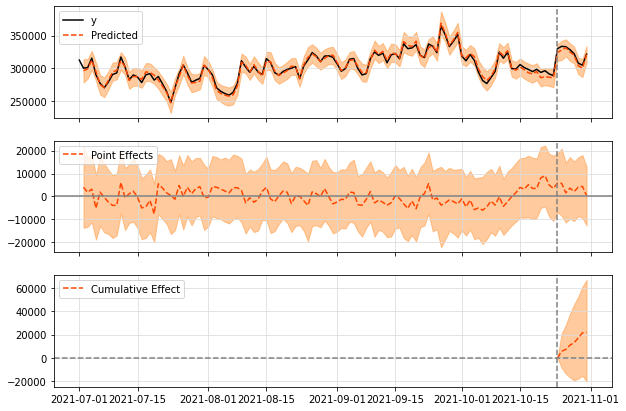

None

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    327862.5           2295037.5
Prediction (s.d.)         317749.72 (2564.2) 2224248.0 (17949.41)
95% CI                    [312786.33, 322837.81][2189504.19, 2259864.59]

Absolute effect (s.d.)    10112.78 (2564.2)  70789.5 (17949.41)
95% CI                    [5024.69, 15076.17][35172.91, 105533.31]

Relative effect (s.d.)    3.18% (0.81%)      3.18% (0.81%)
95% CI                    [1.58%, 4.74%]     [1.58%, 4.74%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


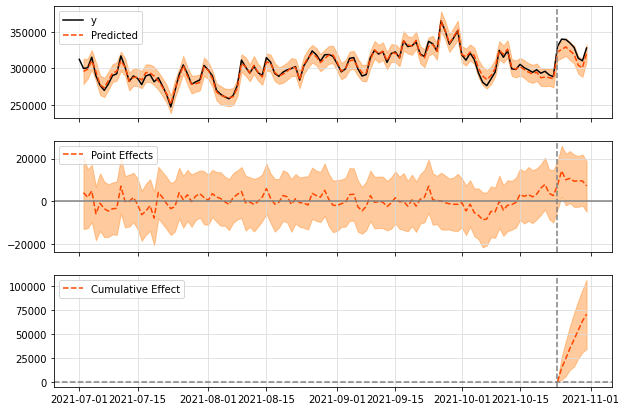

None

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    334228.78          2339601.5
Prediction (s.d.)         318312.78 (2549.97)2228189.5 (17849.8)
95% CI                    [313187.15, 323182.85][2192310.12, 2262280.06]

Absolute effect (s.d.)    15916.0 (2549.97)  111412.0 (17849.8)
95% CI                    [11045.93, 21041.63][77321.44, 147291.38]

Relative effect (s.d.)    5.0% (0.8%)        5.0% (0.8%)
95% CI                    [3.47%, 6.61%]     [3.47%, 6.61%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


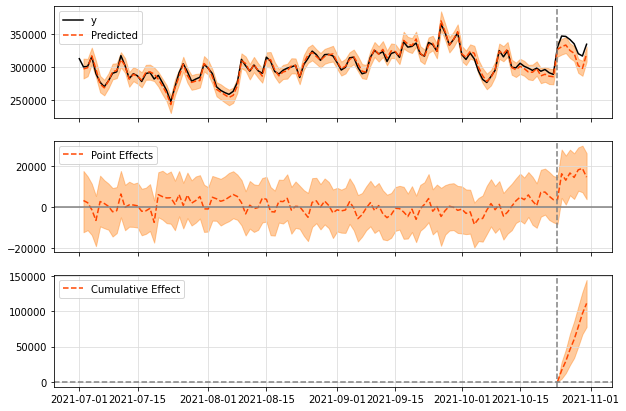

None

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    350144.44          2451011.0
Prediction (s.d.)         318940.72 (2915.52)2232585.0 (20408.62)
95% CI                    [313141.88, 324570.52][2191993.25, 2271993.59]

Absolute effect (s.d.)    31203.72 (2915.52) 218426.0 (20408.62)
95% CI                    [25573.92, 37002.56][179017.41, 259017.75]

Relative effect (s.d.)    9.78% (0.91%)      9.78% (0.91%)
95% CI                    [8.02%, 11.6%]     [8.02%, 11.6%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


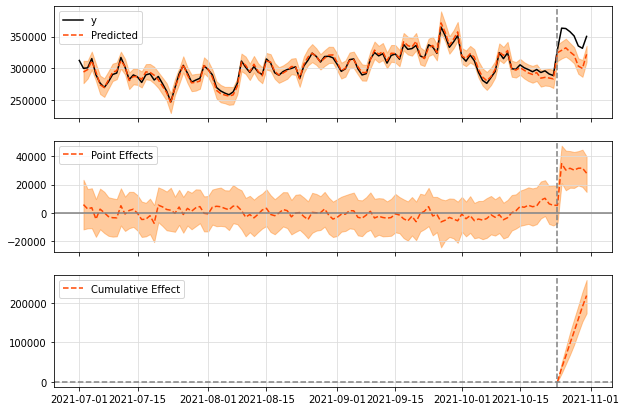

None

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    311667.03          4363338.5
Prediction (s.d.)         305754.69 (2103.03)4280565.5 (29442.4)
95% CI                    [301772.1, 310015.83][4224809.25, 4340221.36]

Absolute effect (s.d.)    5912.34 (2103.03)  82773.0 (29442.4)
95% CI                    [1651.21, 9894.93] [23117.14, 138529.25]

Relative effect (s.d.)    1.93% (0.69%)      1.93% (0.69%)
95% CI                    [0.54%, 3.24%]     [0.54%, 3.24%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.7%

For more details run the command: print(impact.summary('report'))


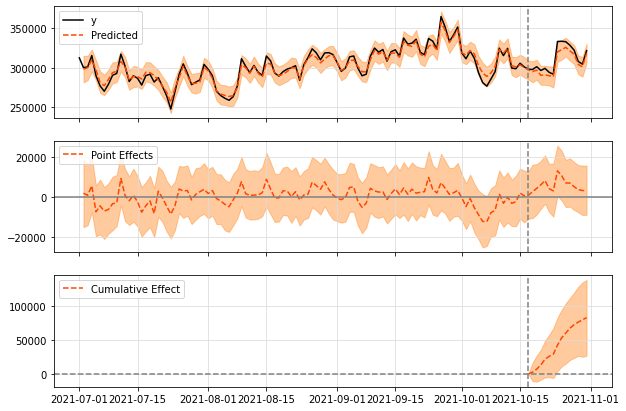

None

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    317838.66          4449741.0
Prediction (s.d.)         306066.72 (2147.49)4284934.0 (30064.8)
95% CI                    [301806.09, 310224.09][4225285.34, 4343137.21]

Absolute effect (s.d.)    11771.94 (2147.49) 164807.0 (30064.8)
95% CI                    [7614.57, 16032.57][106603.79, 224455.66]

Relative effect (s.d.)    3.85% (0.7%)       3.85% (0.7%)
95% CI                    [2.49%, 5.24%]     [2.49%, 5.24%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


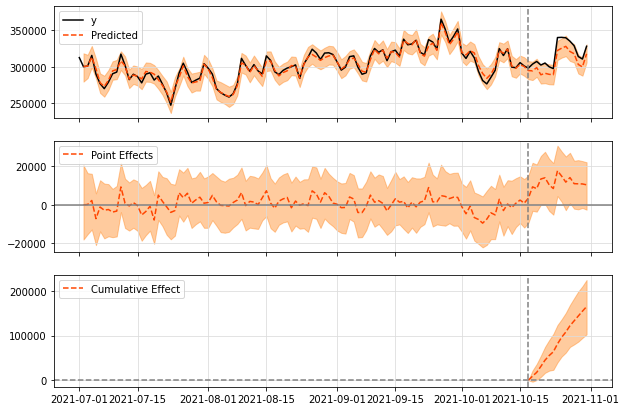

None

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    324010.28          4536144.0
Prediction (s.d.)         305473.75 (2149.98)4276632.5 (30099.64)
95% CI                    [301084.33, 309512.08][4215180.6, 4333169.04]

Absolute effect (s.d.)    18536.53 (2149.98) 259511.5 (30099.64)
95% CI                    [14498.2, 22925.95][202974.96, 320963.4]

Relative effect (s.d.)    6.07% (0.7%)       6.07% (0.7%)
95% CI                    [4.75%, 7.51%]     [4.75%, 7.51%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


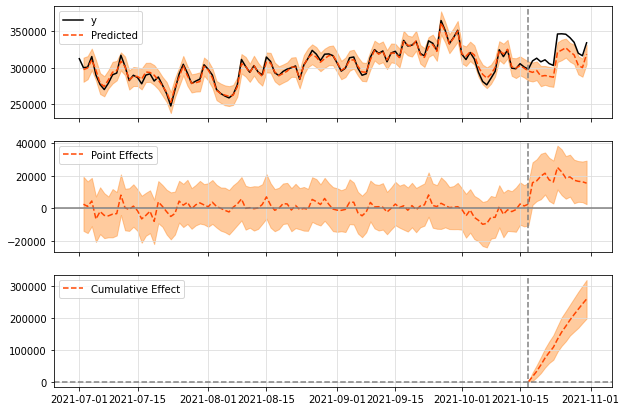

None

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    339439.31          4752150.5
Prediction (s.d.)         306363.69 (2376.58)4289091.5 (33272.08)
95% CI                    [302084.39, 311400.42][4229181.53, 4359605.7]

Absolute effect (s.d.)    33075.62 (2376.58) 463059.0 (33272.08)
95% CI                    [28038.89, 37354.92][392544.8, 522968.97]

Relative effect (s.d.)    10.8% (0.78%)      10.8% (0.78%)
95% CI                    [9.15%, 12.19%]    [9.15%, 12.19%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


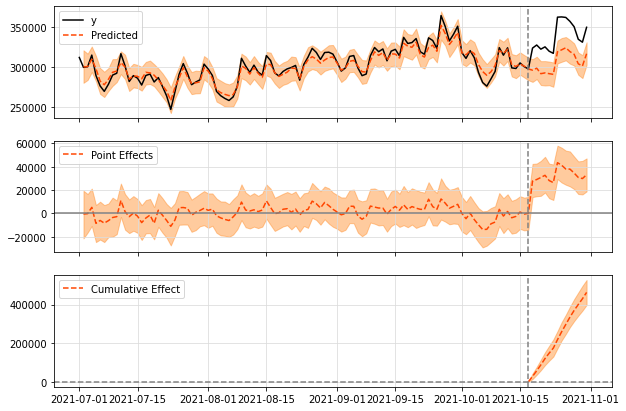

None

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    307702.34          8615666.0
Prediction (s.d.)         305835.47 (2447.99)8563393.0 (68543.96)
95% CI                    [300864.22, 310460.17][8424197.72, 8692885.18]

Absolute effect (s.d.)    1866.88 (2447.99)  52273.0 (68543.96)
95% CI                    [-2757.83, 6838.13][-77219.18, 191468.28]

Relative effect (s.d.)    0.61% (0.8%)       0.61% (0.8%)
95% CI                    [-0.9%, 2.24%]     [-0.9%, 2.24%]

Posterior tail-area probability p: 0.21
Posterior prob. of a causal effect: 79.12%

For more details run the command: print(impact.summary('report'))


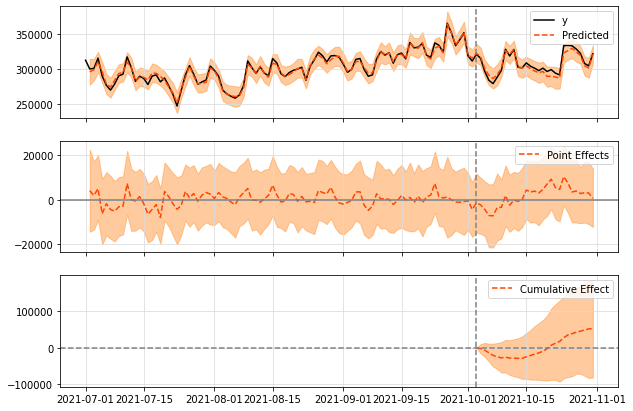

None

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    313795.47          8786273.0
Prediction (s.d.)         305887.28 (2383.45)8564844.0 (66736.7)
95% CI                    [301144.2, 310487.17][8432037.82, 8693640.95]

Absolute effect (s.d.)    7908.19 (2383.45)  221429.0 (66736.7)
95% CI                    [3308.3, 12651.26] [92632.05, 354235.18]

Relative effect (s.d.)    2.59% (0.78%)      2.59% (0.78%)
95% CI                    [1.08%, 4.14%]     [1.08%, 4.14%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.9%

For more details run the command: print(impact.summary('report'))


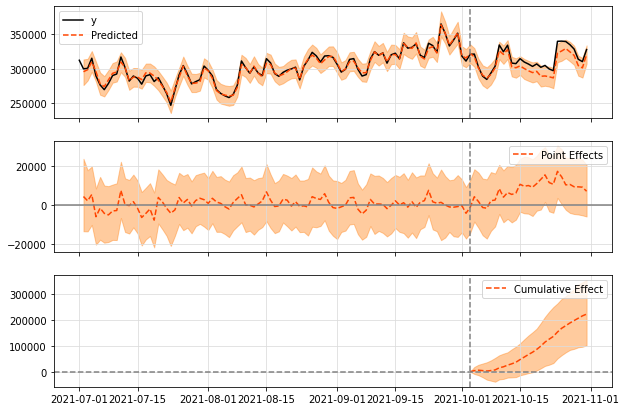

None

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    319888.53          8956879.0
Prediction (s.d.)         304420.53 (2466.11)8523775.0 (69051.02)
95% CI                    [299726.13, 309393.12][8392332.03, 8663007.1]

Absolute effect (s.d.)    15468.0 (2466.11)  433104.0 (69051.02)
95% CI                    [10495.41, 20162.4][293871.9, 564546.97]

Relative effect (s.d.)    5.08% (0.81%)      5.08% (0.81%)
95% CI                    [3.45%, 6.62%]     [3.45%, 6.62%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


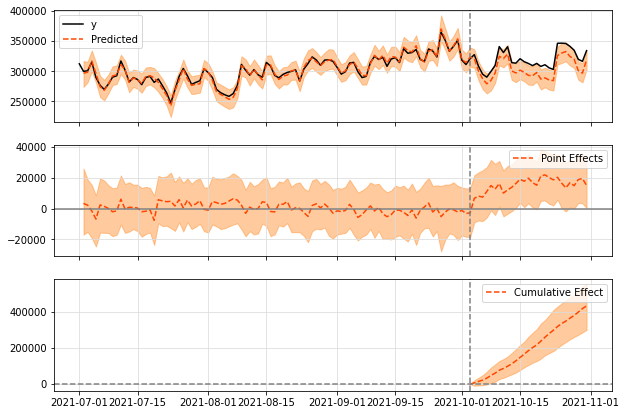

None

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    335121.41          9383399.0
Prediction (s.d.)         305983.72 (2303.77)8567544.0 (64505.74)
95% CI                    [301367.79, 310398.42][8438298.1, 8691156.0]

Absolute effect (s.d.)    29137.69 (2303.77) 815855.0 (64505.74)
95% CI                    [24722.99, 33753.61][692243.0, 945100.9]

Relative effect (s.d.)    9.52% (0.75%)      9.52% (0.75%)
95% CI                    [8.08%, 11.03%]    [8.08%, 11.03%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


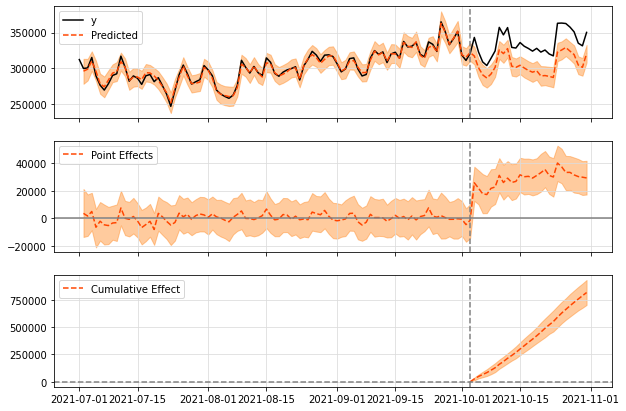

None

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @markdown <font color='blue'><b>■ Simulate and Estimate budget</b></font>

estimation_icpa = 1000  #@param {type: "integer"}
design.simulate_params(df,estimation_icpa)

# CausalImpact

### Load Data

In [ ]:
#@markdown <font color='blue'><b>■ Select your Data Source</b></font>  (google_spreadsheet | csv)
analysis = PreProcess()
data_source = "google_spreadsheet" #@param ["google_spreadsheet", "csv"]
#@markdown <br><hr>

#@markdown If you select <b>data_course = google_spreadsheet</b>, input sheet_url and sheet_name
sheet_url = "https://docs.google.com/spreadsheets/d/1dISrbX1mZHgzpsIct2QXFOWWRRJiCxDSmSzjuZz64Tw/edit#gid=0"  #@param {type:"string"}
sheet_name = "analysis_data"  #@param {type:"string"}


#@markdown <br> If you select <b>data_course = csv</b>, input csv_name
csv_name = "Sample Data for CausalImpact Colab Template - RawData.csv"  #@param {type:"string"}

if data_source == "google_spreadsheet":
  analysis.load_data_from_sheet(
      spreadsheet_url=sheet_url, sheet_name=sheet_name)
else:
  analysis.load_data_from_csv(csv_name=csv_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,date,test,ctrl
0,2021-07-01,115133,70628
1,2021-07-02,108481,65315
2,2021-07-03,106624,66472
3,2021-07-04,112356,69235
4,2021-07-05,107549,68778
5,2021-07-06,102172,61492
6,2021-07-07,98457,61233
7,2021-07-08,101844,63740
8,2021-07-09,108816,64068
9,2021-07-10,108681,65006


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,dtypes
date,object
test,int64
ctrl,int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,date,test,ctrl
count,123,123.000000,123.000000
unique,123,NaN,NaN
top,2021-07-01,NaN,NaN
freq,1,NaN,NaN
mean,NaN,112245.113821,67770.512195
std,NaN,8701.470348,4794.140107
min,NaN,91980.000000,55840.000000
25%,NaN,106352.000000,64547.500000
50%,NaN,111788.000000,67583.000000
75%,NaN,117803.000000,70956.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### CausalImpact Analysis

MAPE: 1.94%
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    118853.94          3684472.0
Prediction (s.d.)         111499.51 (850.12) 3456484.75 (26353.71)
95% CI                    [109924.64, 113257.05][3407663.83, 3510968.5]

Absolute effect (s.d.)    7354.43 (850.12)   227987.25 (26353.71)
95% CI                    [5596.89, 8929.3]  [173503.5, 276808.17]

Relative effect (s.d.)    6.6% (0.76%)       6.6% (0.76%)
95% CI                    [5.02%, 8.01%]     [5.02%, 8.01%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


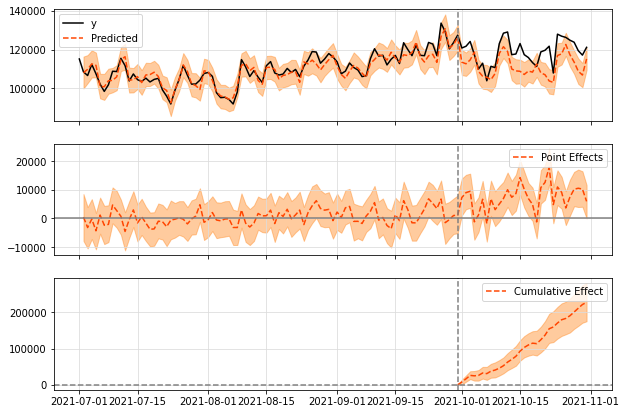

In [ ]:

date_col = 'date'  #@param {type: "string"}
analysis.df_sheet.set_index(date_col, inplace=True)
analysis.df_sheet.index = analysis.df_sheet.index.map(str)

pre_period_start = "2021-07-01" #@param {type:"date"}
pre_period_end = "2021-09-30" #@param {type:"date"}
post_period_start = "2021-10-01" #@param {type:"date"}
post_period_end = "2021-10-31" #@param {type:"date"}
pre_period = [pre_period_start, pre_period_end]
post_period = [post_period_start, post_period_end]

ci = CausalImpact(analysis.df_sheet, pre_period, post_period)
mape = mean_absolute_percentage_error(
                ci.data.test[ci.pre_period[0]:ci.pre_period[1]],
                ci.inferences.complete_preds_means[ci.pre_period[0]:ci.pre_period[1]])
print('MAPE: {0:.2%}'.format(mape))
print(ci.summary())
ci.plot()